In [2]:
import glob
from AIPyS.Baysian_training import bayesModelTraining
import pandas as pd
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc as pm
print(pm.__version__)
import os
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

5.0.0


In [3]:
dir1_pex = 'csv_pex3_0118'
pex_files = [f for f in os.listdir(dir1_pex) if not f.startswith('._')]
df_pex = pd.concat([pd.read_csv(os.path.join(dir1_pex, f)) for f in pex_files])
df_pex

,Unnamed: 0,labeledCell,kernel,intensity,classLabel
0,0,0,0,1.000000,1
1,1,0,16,0.675065,1
2,2,0,14,0.681950,1
3,3,0,8,0.773656,1
4,4,0,6,0.821082,1
...,...,...,...,...,...
5176,5176,470,0,1.000000,1
5177,5177,470,2,0.897764,1
5178,5178,470,16,0.735843,1
5179,5179,470,8,0.792958,1


In [4]:
dir1_pex = 'csv_pex3_0118'
dir2_wt = 'csv_wt_0118'
pex_files = [f for f in os.listdir(dir1_pex) if not f.startswith('._')]
wt_files = [f for f in os.listdir(dir2_wt) if not f.startswith('._')]

In [5]:
df_pex = pd.concat([pd.read_csv(os.path.join(dir1_pex, f)) for f in pex_files])
df_wt = pd.concat([pd.read_csv(os.path.join(dir2_wt, f)) for f in wt_files])

In [6]:
len(df_wt),len(df_pex)

(12716, 21648)

In [7]:
from sklearn.model_selection import train_test_split
train_wt, test_wt = train_test_split(df_wt, test_size=0.2, random_state=43289)
train_pex, test_pex = train_test_split(df_pex, test_size=0.2, random_state=43289)
train = pd.concat((train_wt,train_pex)).sample(frac = 1,random_state=43289)
train.head(2),len(train)

(      Unnamed: 0  labeledCell  kernel  intensity  classLabel
 1306        1306          118      16   0.726444           1
 115          115           10       2   0.875853           1,
 27490)

In [15]:
from AIPyS import AIPS_granularity as ag
files = glob.glob(pathname=dir1_pex+"/*.csv") + glob.glob(pathname=dir2_wt+"\*.csv")
#dfMergeFinel, dfMergeFinelFitelrd, rate, y_0, trace = bayesModelTraining(files = files,kernelSize = 14,pathOut = None, reportFile = None)
# alternative load data insted of 
dfMergeFinel, dfMergeFinelFitelrd, rate, y_0, trace = bayesModelTraining(files = files,kernelSize = 14,pathOut = None, reportFile = None, data = train[:5000])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 39 seconds.


<Figure size 300x100 with 0 Axes>

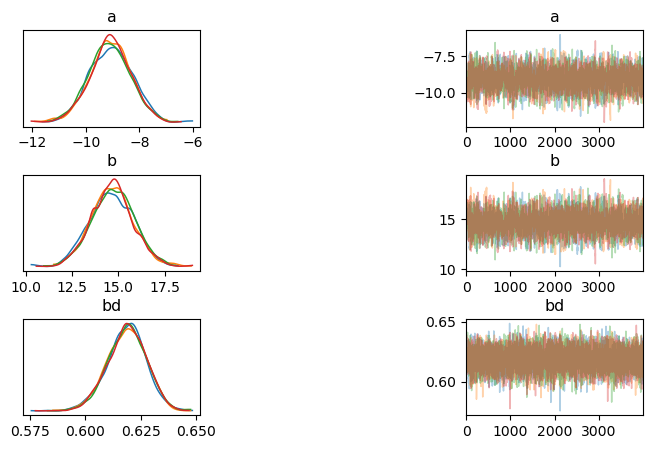

In [16]:
plt.figure(figsize=(3, 1))
az.plot_trace(trace,var_names=["a","b","bd"], figsize=(8, 5), compact=False)
plt.subplots_adjust(wspace = 1.5, hspace=0.5)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

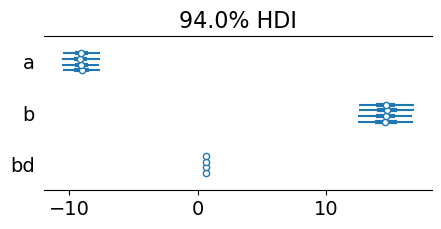

In [17]:
az.plot_forest(trace,kind='forestplot',
                           var_names=["a","b","bd"],
                           combined=False,
                           figsize=(5, 2))

In [18]:
def classify(n, thold, trace):
        '''
        :param n: array of intensities
        :param thold:
        :param trace:
        :return:
        '''
        mu = trace.posterior['a'].mean(dim=("chain", "draw")).values + trace.posterior['b'].mean(dim=("chain", "draw")).values * n
        prob = 1 / (1 + np.exp(-mu))
        return prob, prob > thold
rate = dfMergeFinelFitelrd.intensity.values
td = 0.5
prob, prediction = classify(rate, td, trace)
y_true = y_0
y_pred = np.where(prediction == True, 1, 0)
performance = precision_recall_fscore_support(y_true, y_pred, average='macro')

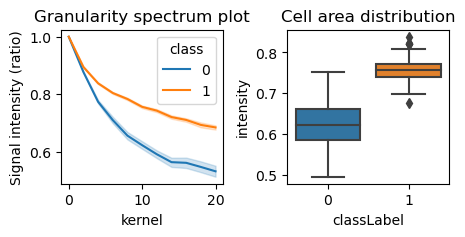

In [13]:
dfline = pd.DataFrame({"kernel": dfMergeFinel.kernel.values, "Signal intensity (ratio)": dfMergeFinel.intensity.values,
                         "class": dfMergeFinel.classLabel.values})
classLabel = dfMergeFinelFitelrd.classLabel.values.tolist()
intensity = dfMergeFinelFitelrd.intensity.values.tolist()
df = pd.DataFrame({"classLabel": classLabel, "intensity": intensity})
fig, ax = plt.subplots(1,2,figsize=(5, 2))
sns.lineplot(data=dfline, x="kernel", y="Signal intensity (ratio)", hue="class", ax= ax[0]).set(title='Granularity spectrum plot')
sns.boxplot(data=df, x="classLabel", y="intensity", ax = ax[1]).set(title='Cell area distribution')
fig.subplots_adjust(wspace= 0.4) 

Text(0, 0.1, 'b :14.67')

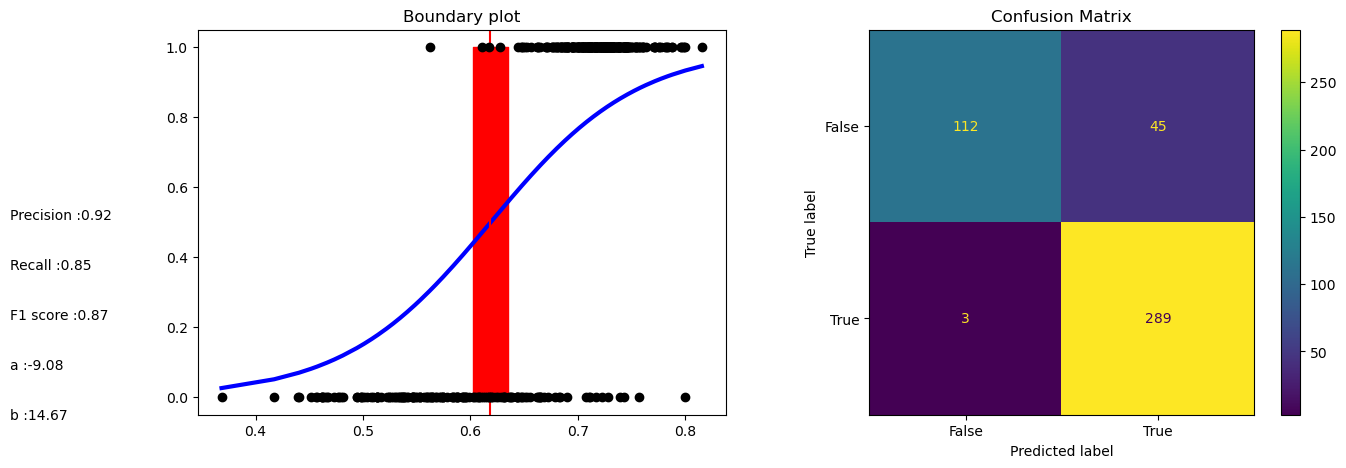

In [19]:
fig,ax = plt.subplots(1,2,figsize=(15, 5))
idx = np.argsort(rate)
theta = trace.posterior['theta'].mean(dim=("chain", "draw")).values
ax[0].set_title('Boundary plot')
ax[0].plot(rate[idx], theta[idx], color='b', lw=3)
ax[0].axvline(trace.posterior['bd'].mean(), ymax=1, color='r')
bd_hdi = pm.hdi(trace.posterior['bd'])
bd_low = pm.hdi(trace.posterior['bd']).sel(hdi='lower')['bd'].values
bd_high = pm.hdi(trace.posterior['bd']).sel(hdi='higher')['bd'].values
ax[0].fill_betweenx([0, 1], bd_low, bd_high, color='r')
ax[0].plot(rate, y_0, 'o', color='k')

confusion_matrix = metrics.confusion_matrix(np.array(dfMergeFinelFitelrd.classLabel.values, dtype=int),np.where(prediction, 1, 0))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix')
ax[1].text(0, 0.5, "Precision :{}".format(np.round(performance[0],2)), fontsize=10, transform=plt.gcf().transFigure)
ax[1].text(0, 0.4, "Recall :{}".format(np.round(performance[1],2)), fontsize=10, transform=plt.gcf().transFigure)
ax[1].text(0, 0.3, "F1 score :{}".format(np.round(performance[2],2)), fontsize=10, transform=plt.gcf().transFigure)
ax[1].text(0, 0.2, "a :{}".format(np.round(trace.posterior['a'].mean().values, 2)), fontsize=10,transform=plt.gcf().transFigure)
ax[1].text(0, 0.1, "b :{}".format(np.round(trace.posterior['b'].mean().values, 2)), fontsize=10,transform=plt.gcf().transFigure)